Create dataset fruit_store.
In traditional relational database SQL, we use normalization (going from one table to many). 
For data warehousing, data analysts often go the reverse direction (denormalization) and bring many 
separate tables into one large reporting table.
**array should be same type**
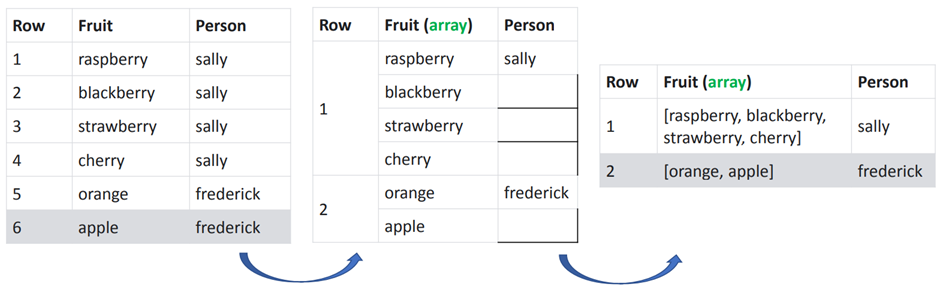

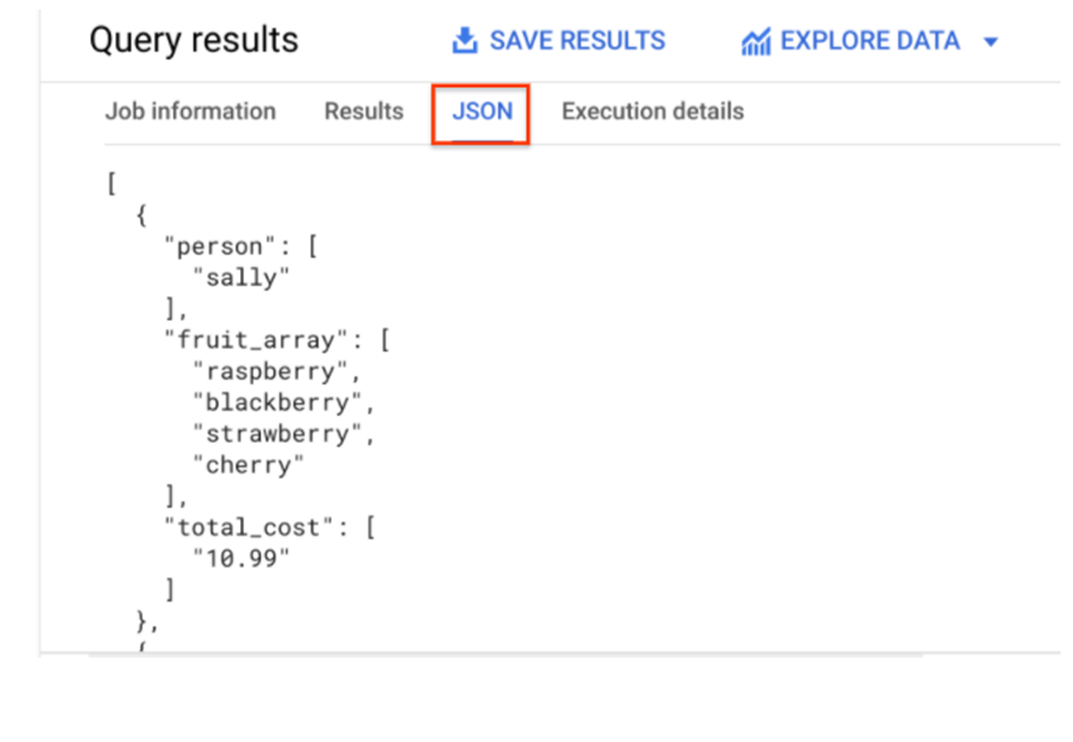

### Loading semi-structured JSON into BigQuery

• Create a new table in the fruit_store dataset twith following details :
•Source: Choose Google Cloud Storage in the Create table from dropdown. <br>
•Select file from GCS bucket (type or paste the following): data-insights-course/labs/optimizing-forperformance/shopping_cart.json <br>
•File format: JSONL (Newline delimited JSON) {This will be auto-populated} <br>
•Schema: Check Auto detect (Schema and input parameters). <br>
• Call the new table "fruit_details" <br>

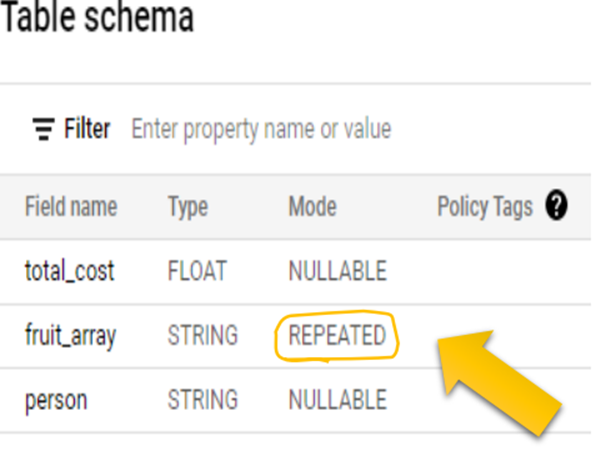

in the schema, note that fruit_array is marked as 
REPEATED which means it's an array. <br>
Recap  <br>
•BigQuery natively supports arrays <br>
•Array values must share a data type <br>
•Arrays are called REPEATED fields in BigQuery <br>

### Creating your own arrays with ARRAY_AGG(), ARRAY_LENGTH()

In [ ]:
SELECT
fullVisitorId,
date,
v2ProductName,
pageTitle
FROM `data-toinsights.ecommerce.all_sessions`
WHERE visitId = 1501570398
ORDER BY date

In [ ]:
SELECT
fullVisitorId,
date,
ARRAY_AGG(v2ProductName) AS 
products_viewed,
ARRAY_AGG(pageTitle) AS 
pages_viewed
FROM `data-to-insights.ecommerce.all_sessions`
WHERE visitId = 1501570398
GROUP BY fullVisitorId, date
ORDER BY date

In [ ]:
SELECT
fullVisitorId,
date,
ARRAY_AGG(v2ProductName) AS 
products_viewed,
ARRAY_LENGTH(ARRAY_AGG(v2ProductName)) 
AS num_products_viewed,
ARRAY_AGG(pageTitle) AS pages_viewed,
ARRAY_LENGTH(ARRAY_AGG(pageTitle)) AS 
num_pages_viewed
FROM `data-to-insights.ecommerce.all_sessions`
WHERE visitId = 1501570398
GROUP BY fullVisitorId, date
ORDER BY date

In [ ]:
-- You need to UNNEST() arrays to bring the array 
-- elements back into rows

SELECT DISTINCT
visitId,
h.page.pageTitle
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`,
UNNEST(hits) AS h
WHERE visitId = 1501570398
LIMIT 10

### STRUCTs
That SQL data type is the STRUCT data type.
The easiest way to think about a STRUCT is to consider it 
conceptually
like a separate table that is already pre-joined into your main table.
A STRUCT can have:
•one or many fields in it
•the same or different data types for each field
•it's own alias
Add public dataset ga_sessions , you find struct fields e.g. 
Totals , TrafficSource , device , trafficSource.adwordsClickInfo

•Structs are containers that can have 
multiple field names and data types 
nested inside. <br>
•An arrays can be one of the field types 
inside of a Struct (as shown above with 
the splits field). <br>

get granular data from ARRAYs when you need it 
but not be punished if you don't (BigQuery stores 
each column individually on disk) <br>
•NO joins ➔ high performance  <br>
•have all the business context in one table as 
opposed to worrying about JOIN keys and which 
tables have the data you need <br>

In [ ]:
SELECT
visitId,
totals.*,
device.*
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE visitId = 1501570398
LIMIT 10

In [ ]:
SELECT STRUCT("Rudisha" as name, 23.4 as split) as runner ;
SELECT STRUCT("Rudisha" as name, [23.4, 26.3, 26.4, 26.1] as splits) AS runner

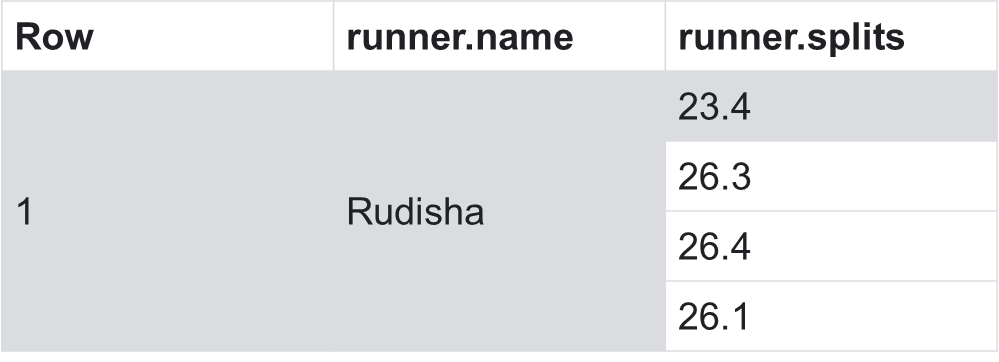

### Practice ingesting JSON data

1.Create a new dataset titled racing. <br>
2.Create a new table titled race_results. <br>
3.Ingest this Google Cloud Storage JSON file:   <br>
data-insights-course/labs/optimizing-for-performance/race_results.json <br>
•Source: Google Cloud Storage under Create      <br>
table from dropdown. <br>
•Select file from GCS bucket: data-insights-course/labs/optimizing-for-performance/race_results.json <br>
•File format: JSONL (Newline delimited JSON) <br>
•In Schema, move the Edit as text slider and add 
the following <br>
•Preview table and discover structs and arrays <br>

```sql
[
{
"name": "race",
"type": "STRING",
"mode": "NULLABLE"
},
{
"name": "participants",
"type": "RECORD",
"mode": "REPEATED",
"fields": [
{
"name": "name",
"type": "STRING",
"mode": "NULLABLE"
},
{
"name": "splits",
"type": "FLOAT",
"mode": "REPEATED"
}
]
}
]
```

### Queries

In [ ]:
 
-- Let's see all of our racers for the 800 Meter race
-- #standardSQL
SELECT * FROM racing.race_results

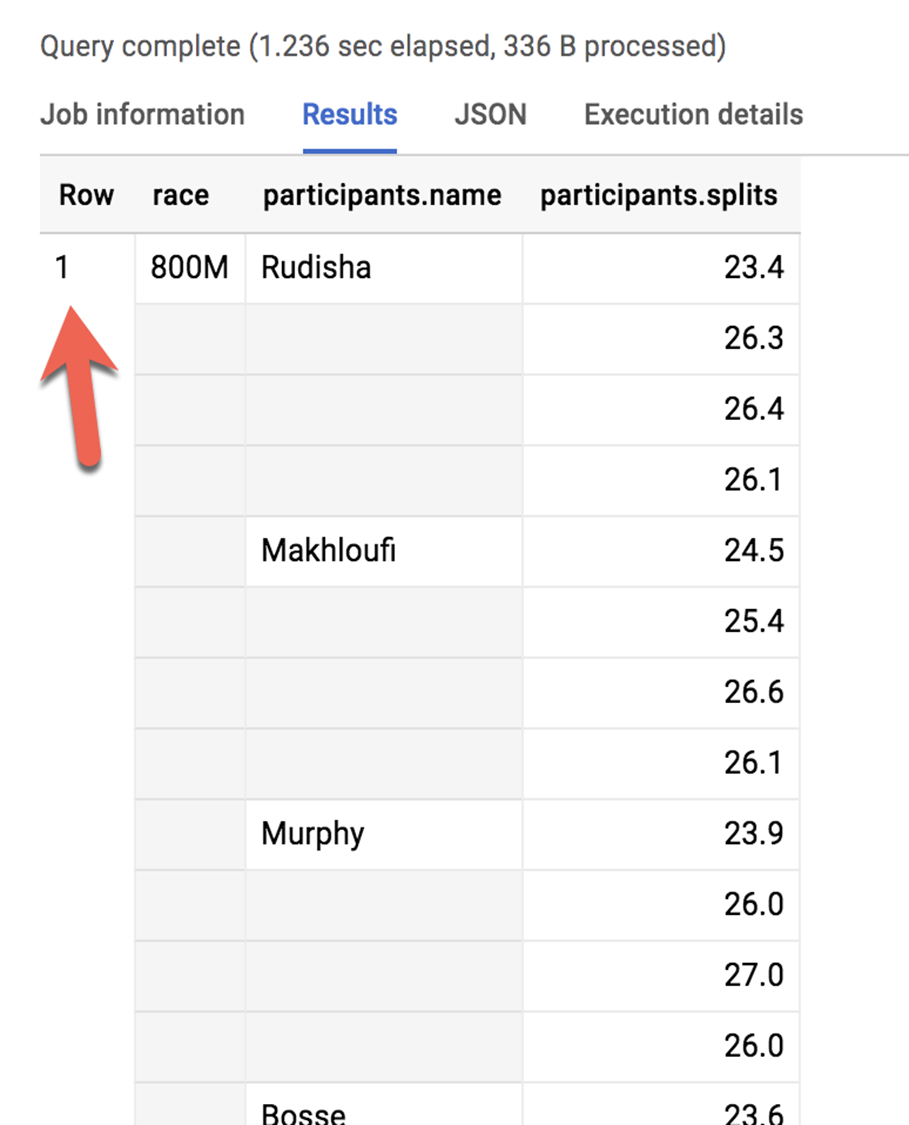

2.What if you wanted to list the name of each runner and the type of race? <br>
Run the below schema and see what happens: <br>
```sql
SELECT race, participants.name
FROM racing.race_results
```
Error: Cannot access field name on a value with type ARRAY\<STRUCT\<name STRING, splits ARRAY\<FLOAT64\>>>> at [1:21]
Much like forgetting to GROUP BY when you use aggregation functions, here there are two different levels of 
granularity. One row for the race and three rows for the participants names. So how do you change this...

if you want to go from form1 to form2
 
|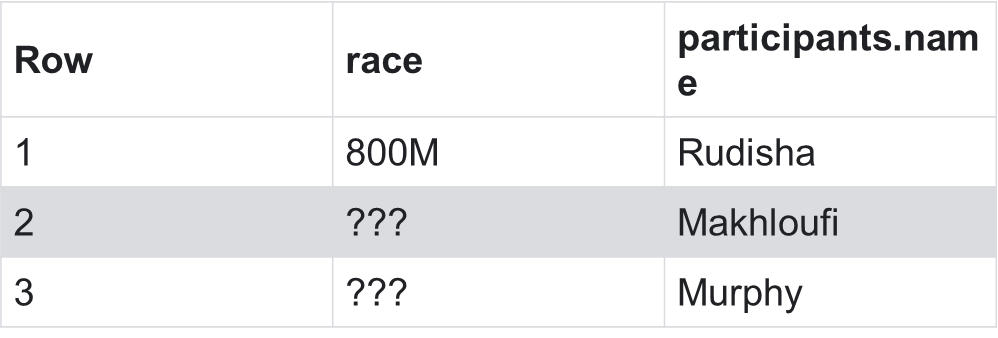|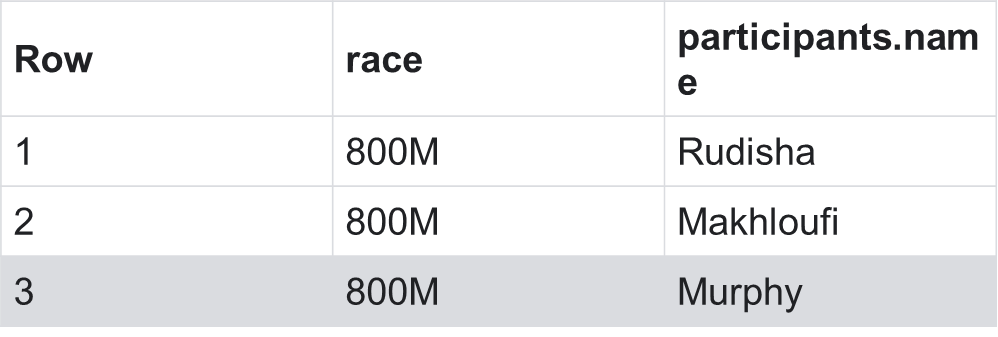|


**Answer: CROSS JOIN**
```sql
SELECT race, participants.name
FROM racing.race_results
CROSS JOIN
participants -- this is the STRUCT (it's like a table within a table)
```

Error: Table name "participants" cannot be resolved: dataset name is missing.
Even though the participants STRUCT is like a table, it is still technically a field in the racing.race_results table

In [ ]:

SELECT race, participants.name
FROM racing.race_results
CROSS JOIN
race_results.participants -- full STRUCT name
-- or you can use the next query 
SELECT race, participants.name
FROM racing.race_results AS r, 
r.participants



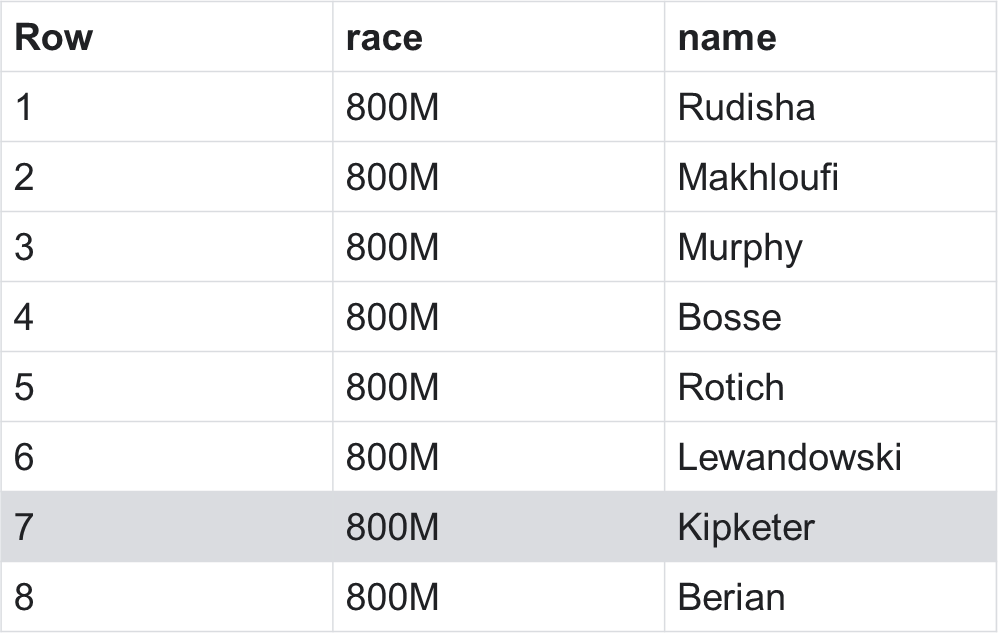

In [ ]:
-- Task: Write a query to COUNT how many racers were there in total.

SELECT COUNT(p.name) AS racer_count
FROM racing.race_results AS r, UNNEST(r.participants) AS p


In [ ]:
-- Write a query that will list the total race time for racers 
-- whose names begin with R. Order the results with the 
-- fastest total time first. Use the UNNEST() operator

SELECT
p.name,
SUM(split_times) as total_race_time
FROM racing.race_results AS r
, UNNEST(r.participants) AS p
, UNNEST(p.splits) AS split_times
WHERE p.name LIKE 'R%'
GROUP BY p.name
ORDER BY total_race_time ASC;


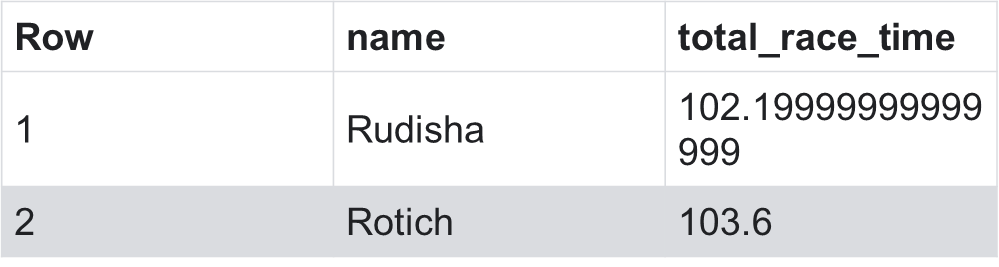

In [ ]:
-- Filtering within ARRAY values
-- You happened to see that the fastest lap time recorded for the 800 M race was 23.2 seconds, but you did not see 
-- which runner ran that particular lap

In [ ]:
SELECT
p.name,
split_time
FROM racing.race_results AS r
, UNNEST(r.participants) AS p
, UNNEST(p.splits) AS split_time
WHERE split_time = 23.2;
